In [ ]:
# Задание вытащить все вакансии СБЕРа с ХХ (у апи есть ограничение в 2000, подумайте как его обойти)
# Вытащите все описания этих вакансий
# Создайте аналогичный vacancy DataFrame только добавьте поле skills
# Переведите даты публикаций в datetime
# Постройте график опубликованных вакансий по датам
# Переведите даты в дни недели, и определите день недели, в который больше всего публикуют вакансий
# Найдите те вакансии с использованием python, которые вам интересны
# Определите по полю skills какие навыки больше всего востребованы для этих вакансий, и
# Постройте график наиболее востребованных вакансий

In [237]:
%matplotlib notebook
import requests
import json
from tqdm.auto import tqdm
from collections import defaultdict, Counter
import pickle 
import pandas as pd
from datetime import date, timedelta
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
company = '3529'       # all Sber companies
area = 113             # Russia overall
url = f'https://api.hh.ru/vacancies?employer_id={company}&area={area}'
res = requests.get(url)
vacancies = res.json()
#vac_id = set()
vac_id = []
d = int(input("Input the delta parameter (days range for iterative search). Recommended value - 2\n"))
date_range = [date.today() - timedelta(d), date.today()]

while date_range[1] > (date.today() - timedelta(31)):
    url_period = url + f'&date_from={str(date_range[0])}&date_to={str(date_range[1])}'
    print('Progress for the period of:', str(date_range[0])+' - '+str(date_range[1]))
    date_range = list(map(lambda x: x - timedelta(d + 1), date_range))
    vac_period = requests.get(url_period).json()
    for page in tqdm(range(vac_period['pages'])):
        vac_page = requests.get(url_period + f'&page={page}').json()
        #vac_id = vac_id.union(set([el['id'] for el in vac_page['items']]))
        vac_id.extend([el['id'] for el in vac_page['items']])

if len(vac_id) < vacancies['found']:
    print('NOT all vacancies are loaded! ', len(vac_id), ' out of ', vacancies['found'], 
          ' Try to restart the programme reducing delta parameter.\n', 
          'WARNING - reducing delta parameter will cause increase of performance time due to more precise search',
          sep='')
else:
    print('All vacancies are loaded!', len(vac_id), 'out of', vacancies['found'])

Input the delta parameter (days range for iterative search). Recommended value - 2
1
Progress for the period of: 2021-07-27 - 2021-07-28



Progress for the period of: 2021-07-25 - 2021-07-26



Progress for the period of: 2021-07-23 - 2021-07-24



Progress for the period of: 2021-07-21 - 2021-07-22



Progress for the period of: 2021-07-19 - 2021-07-20



Progress for the period of: 2021-07-17 - 2021-07-18



Progress for the period of: 2021-07-15 - 2021-07-16



Progress for the period of: 2021-07-13 - 2021-07-14



Progress for the period of: 2021-07-11 - 2021-07-12



Progress for the period of: 2021-07-09 - 2021-07-10



Progress for the period of: 2021-07-07 - 2021-07-08



Progress for the period of: 2021-07-05 - 2021-07-06



Progress for the period of: 2021-07-03 - 2021-07-04



Progress for the period of: 2021-07-01 - 2021-07-02



Progress for the period of: 2021-06-29 - 2021-06-30



Progress for the period of: 2021-06-27 - 2021-06-28



All vacancies are loaded! 6269 out of 6269


In [5]:
columns = ['id', 'name', 'department', 'published_at', 'description', 'salary', 'experience', 'key_skills', 'area']
df_dict = defaultdict(list)
id_exc = []
for i in tqdm(vac_id):
    try:
        tmp = requests.get(f'https://api.hh.ru/vacancies/{i}').json()
    except:
        id_exc.append(i)
    else:
        for col in columns:
            df_dict[col].append(tmp.get(col, np.nan))

In [10]:
# Got my internet connection lost on the previous step,
# continuing loading data for the rest part, which got
# caught in exception list id_exc

id_exc2 = []
for i in tqdm(id_exc):
    try:
        tmp = requests.get(f'https://api.hh.ru/vacancies/{i}').json()
    except:
        id_exc2.append(i)
    else:
        for col in columns:
            df_dict[col].append(tmp.get(col, np.nan))

In [29]:
df_vac = pd.DataFrame(df_dict)
if df_vac['id'].count() == vacancies['found']:
    print('All vacancies are in dataframe:', df_vac['id'].count(),
         'out of', vacancies['found'])
else:
    print('NOT all vacancies are in dataframe: only', df_vac['id'].count(), 
          'out of', vacancies['found'])

NOT all vacancies are in dataframe: only 4000 out of 6269


In [47]:
# Turns out HH API's captcha was triggered, my requests starting
# from id #4001 were declined by server.
# Detecting last id captured and continuing loading data for the rest part

last_id = df_vac['id'].iloc[df_vac['id'].count() - 1]
df_dict2 = defaultdict(list)

for i in tqdm(id_exc[id_exc.index(last_id) + 1:]):
    try:
        tmp = requests.get(f'https://api.hh.ru/vacancies/{i}').json()
    except:
        id_exc2.append(i)
    else:
        for col in columns:
            df_dict2[col].append(tmp.get(col, np.nan))

In [55]:
df_vac = pd.concat([df_vac.dropna(how='all'), pd.DataFrame(df_dict2)])

if df_vac['id'].count() == vacancies['found']:
    print('All vacancies are in dataframe:', df_vac['id'].count(),
         'out of', vacancies['found'])
else:
    print('NOT all vacancies are in dataframe: only', df_vac['id'].count(), 
          'out of', vacancies['found'])

All vacancies are in dataframe: 6269 out of 6269


In [56]:
with open('df_vac.pickle', 'wb') as f:
    pickle.dump(df_vac, f)
with open('df_dict.pickle', 'wb') as f:
    pickle.dump(df_dict, f)
with open('df_dict2.pickle', 'wb') as f:
    pickle.dump(df_dict2, f)

<IPython.core.display.Javascript object>


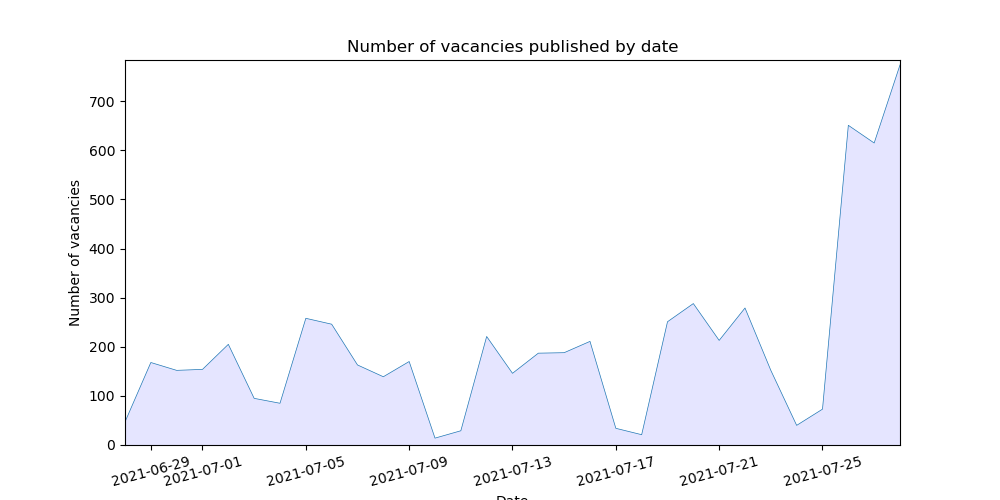

Text(0.5, 1.0, 'Number of vacancies published by date')

In [117]:
df_vac['published_at'] = pd.to_datetime(df_vac['published_at'])
df_vac['date'] = df_vac['published_at'].apply(lambda x: x.date())

plt.figure(figsize=(10, 5))
plt.plot(df_vac['date'].sort_values().unique(),
         df_vac.set_index('published_at').resample('D').count()['id'].values,
        lw=0.5)

plt.gca().fill_between(df_vac['date'].sort_values().unique(), 
                       df_vac.set_index('published_at').resample('D').count()['id'].values, 
                       facecolor='blue', 
                       alpha=0.1)

plt.gca().axis([df_vac['date'].sort_values().unique()[0], df_vac['date'].sort_values().unique()[-1], 
                0, df_vac.set_index('published_at').resample('D').count()['id'].values.max() + 10])

x = plt.gca().xaxis
for item in x.get_ticklabels():
    item.set_rotation(15)

plt.xlabel('Date')
plt.ylabel('Number of vacancies')
plt.title("Number of vacancies published by date")

<IPython.core.display.Javascript object>


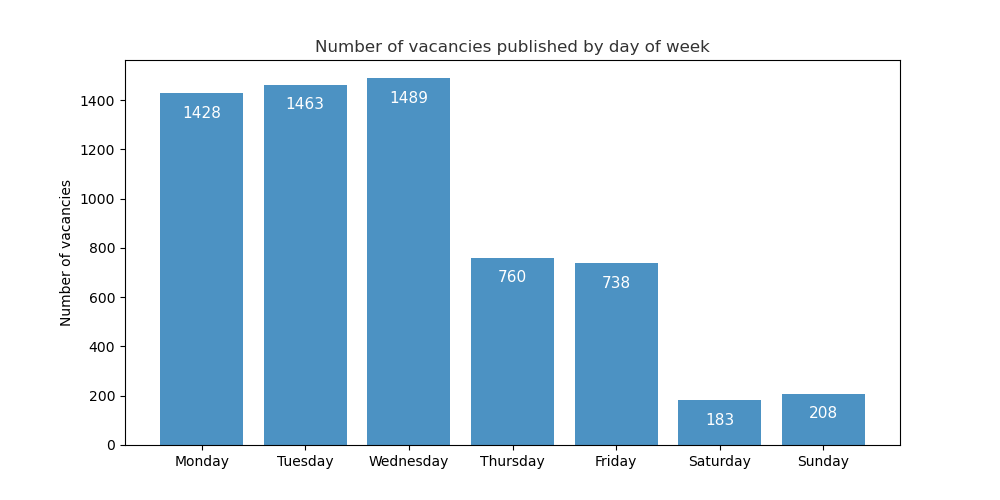

In [168]:
df_vac['weekday'] = df_vac['published_at'].apply(lambda x: x.day_name())
weekorder = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_vac = [df_vac.groupby('weekday').count()['id'][day] for day in weekorder]

plt.figure(figsize=(10, 5))
bars = plt.bar(range(7), weekday_vac, align='center', linewidth=0, alpha=0.8)
plt.xticks(range(7), weekorder)
plt.ylabel('Number of vacancies')
plt.title('Number of vacancies published by day of week', alpha=0.8)

for bar in bars:
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() - 100, str(int(bar.get_height())), 
                 ha='center', color='w', fontsize=11)

In [264]:
pd.set_option('display.max_colwidth', None)
df_python = df_vac[(df_vac['description'].str.lower().str.contains('python')) | 
                   (df_vac['description'].str.lower().str.contains('питон')) | 
                   (df_vac['description'].str.lower().str.contains('пайтон')) ]

df_fav = df_python[(df_python['name'].str.lower().str.contains('scien')) | 
                   (df_python['name'].str.lower().str.contains('analy')) | 
                   (df_python['name'].str.lower().str.contains('анали')) |
                   (df_python['name'].str.lower().str.contains('data'))]

df_fav['skills'] = df_fav['key_skills'].apply(lambda x: ','.join([i['name'] for i in x]))
skills_fav = Counter([el for row in list(map(lambda x: x.split(','), df_fav['skills'].values)) for el in row if len(el) != 0])
print(*skills.most_common(10), sep='\n')

('Python', 46)
('SQL', 36)
('Hadoop', 8)
('Английский язык', 7)
('Математическая статистика', 7)
('Linux', 7)
('PostgreSQL', 6)
('SCALA', 5)
('Анализ данных', 5)
('C++', 4)


<ipython-input-264-0c8729ed3951>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fav['skills'] = df_fav['key_skills'].apply(lambda x: ','.join([i['name'] for i in x]))


<IPython.core.display.Javascript object>


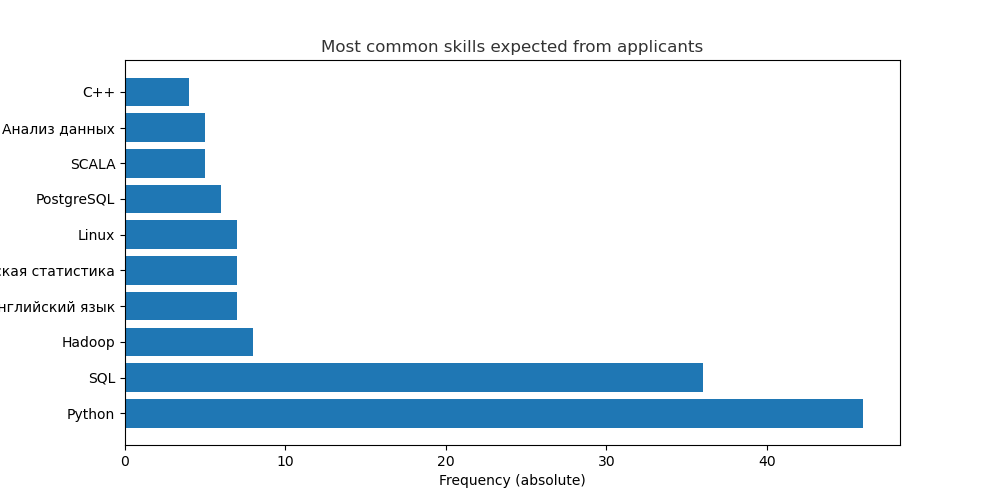

Text(0.5, 1.0, 'Most common skills expected from applicants')

In [288]:
plt.figure(figsize=(10, 5))
plt.barh(list(map(lambda x: x[0], skills.most_common(10))), list(map(lambda x: x[1], skills.most_common(10))))
plt.xlabel('Frequency (absolute)')
plt.title('Most common skills expected from applicants', alpha=0.8)

In [286]:
skills_overall = Counter([el for row in list(map(lambda x: x.split(','), 
                                                 df_vac['key_skills'].apply(lambda x: ','.join([i['name'] for i in x])).values))
                          for el in row if len(el) != 0])
skills_overall.most_common(10)

[('Активные продажи', 973),
 ('Работа в команде', 922),
 ('Клиентоориентированность', 819),
 ('Грамотная речь', 591),
 ('Прямые продажи', 481),
 ('Кредитные договоры', 462),
 ('Холодные продажи', 425),
 ('Обучение и развитие', 341),
 ('Ориентация на результат', 284),
 ('SQL', 263)]

In [294]:
df_fav['city'] = df_fav['area'].apply(lambda x: x.get('name'))
print(*Counter(df_fav['city']).most_common(20), sep='\n')

('Москва', 119)
('Санкт-Петербург', 22)
('Екатеринбург', 7)
('Нижний Новгород', 4)
('Самара', 4)
('Омск', 4)
('Новосибирск', 2)
('Сочи', 1)
('Хабаровск', 1)
('Воронеж', 1)
('Пермь', 1)


<ipython-input-294-3c83ca0ace6f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fav['city'] = df_fav['area'].apply(lambda x: x.get('name'))


In [299]:
df_fav['exp'] = df_fav['experience'].apply(lambda x: x.get('name'))
print(*Counter(df_fav['exp']).most_common(20), sep='\n')

('От 1 года до 3 лет', 91)
('Нет опыта', 49)
('От 3 до 6 лет', 26)


<ipython-input-299-5540f8f1b1a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fav['exp'] = df_fav['experience'].apply(lambda x: x.get('name'))


<ipython-input-319-6c973f5fff4e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fav['name_short'] = df_fav['name'].apply(lambda x: ' '.join(list(map(lambda x: x.lower(), x.split()[:2]))))


<IPython.core.display.Javascript object>


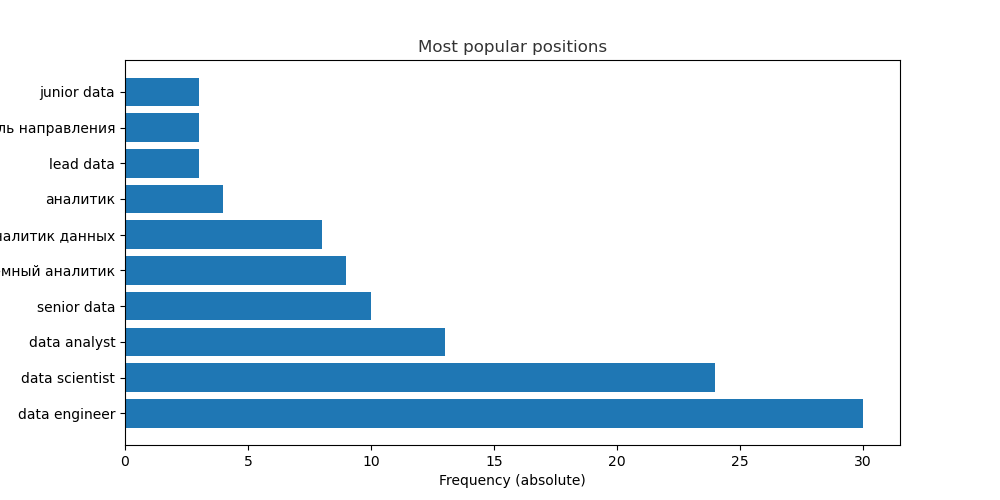

Text(0.5, 1.0, 'Most popular positions')

In [319]:
df_fav['name_short'] = df_fav['name'].apply(lambda x: ' '.join(list(map(lambda x: x.lower(), x.split()[:2]))))

plt.figure(figsize=(10, 5))
plt.barh(df_fav.groupby('name_short').count()['id'].sort_values(ascending=False).head(10).index, 
        df_fav.groupby('name_short').count()['id'].sort_values(ascending=False).head(10).values)
plt.xlabel('Frequency (absolute)')
plt.title('Most popular positions', alpha=0.8)